# V.1: Exploring the green reds

### a) Write a function that will plot a scatterplot matrix of your red wine data

In [13]:
import sys
import shutil
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    numvars = len(wine_data.columns)
    fig = plt.figure(figsize = (13, 13))
    
    good_wines = wine_data.loc[wine_data['quality'] >= good_threshold]
    bad_wines = wine_data.loc[wine_data['quality'] <= bad_threshold]
    
    for i in range(0, numvars):
        for j in range(0, numvars):
            ax = fig.add_subplot(numvars, numvars, i * numvars + j + 1)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            if i == j:
                ax.annotate(wine_data.columns[i].replace(' ', '\n'), (0.5, 0.5), xycoords = 'axes fraction', ha = 'center', va = 'center')
            else:
                x = bad_wines.iloc[1:bad_wines.shape[0], j].values
                y = bad_wines.iloc[1:bad_wines.shape[0], i].values
                ax.scatter(x, y, s = 0.4, c = 'magenta')
                x = good_wines.iloc[1:good_wines.shape[0], j].values
                y = good_wines.iloc[1:good_wines.shape[0], i].values
                ax.scatter(x, y, s = 0.4, c = 'green') 
                
    fig.subplots_adjust(wspace = 0, hspace = 0)
    gs = gridspec.GridSpec(4, 4)
    if save_plot == True:
        fig.savefig('graph.png')
    fig.show()

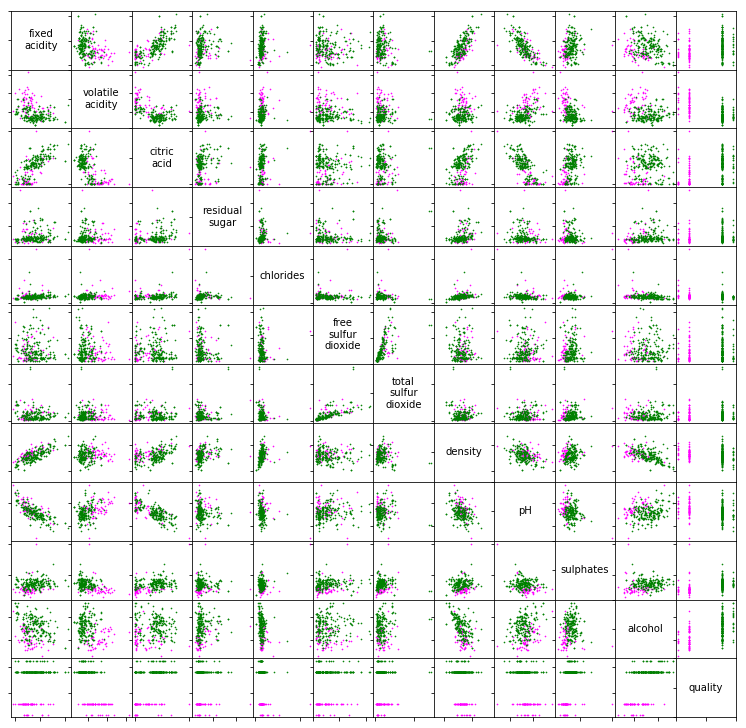

In [14]:
import pandas as pd

df = pd.read_csv('winequality-red.csv', sep = ';')
plot_scatter_matrix(df, 7, 4, False)

### b) Now that you’ve had a chance to analyze different chemical factors in red wines and their relationship with high scores (8 or higher) and low scores (3 or lower), which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?

Good wines seem to be low in chlorides and high in sulfates. Also a high alcohol percentage seems important to the quality of the wine. Citric acid also has a positive corrolation when it comes to flavor, while volatile acidity has a negative corrolation.

# V.2 Learning to perceptron

### a) Implement a perceptron that:
• Has randomly initialized weights and bias  
• Uses the Rosenblatt perceptron learning rule (with changeable learning rate)  
• Utilizes the heaviside step activation function (discrete version)  

### b) You’ll need to implement a function to train your perceptron. Your training function should take in your red wine data as a parameter and should:
• Have a way to specify number of training epochs  
• Train your perceptron until it makes no errors, if training epochs is set to 0  
• Have a way to specify learning rate.  
• Return a list of python tuples containing performance  

In [15]:
import random
import pandas as pd
import math
import copy

def dot_product(x, y):
    result = 0
    for i, j in zip(x, y):
        result += i * j
    return result

class Perceptron(object):
    
    def __init__(self, weights = 0):
        if weights == 0:
            self.weights = []
        else:
            self.weights = [random.uniform(-1.0, 1.0) for _ in range(weights)]
        self.bias = random.uniform(-1.0, 1.0)
    
    def train(self, wine_data, expected_result, learning_rate = 0.01, epochs = 0):       
        self.weights = [random.uniform(-1.0, 1.0) for _ in range(wine_data.shape[1])]
        self.bias = random.uniform(-1.0, 1.0)
        
        performance_list = []
        current_epoch = 0
        
        while True:
            performance = []
            performance.append(current_epoch)
            errors = 0
            
            for xi, target in zip(wine_data, expected_result):
                update = learning_rate * (target - self.predict(xi))
                self.weights += update * xi
                self.bias += update
                errors += int(update != 0.0)
                
            performance.append(self.classification_errors(wine_data, expected_result))
            performance.append(copy.deepcopy(self.weights))
            performance.append(self.bias)
            performance_list.append(performance)
            
            if epochs != 0:
                if current_epoch == epochs:
                    break
            else:
                if errors == 0:
                    break
            current_epoch += 1
        return performance_list
    
    def predict(self, wine_data):
        return (1 if dot_product(wine_data, self.weights) + self.bias >= 0.0 else -1)
    
    def classification_errors(self, wine_data, expected_result):
        errors = 0
        for data, target in zip(wine_data, expected_result):
            if self.predict(data) != target:
                errors += 1
        return errors

### c) Now that you have a perceptron, a way to train your perceptron, and some data, you need a way to confirm that your perceptron actually works.
Write a function that will take the output of your perceptron training function and your red wine data and generate two plots in one figure

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator 

def plot_error_char(performance, epoch = -1):
    """Plotting performance to show errors over time"""
    if epoch < 0:
        plt.plot(range(len(performance)), [x[1] for x in performance], marker = '')
    else:
        plt.plot(range(epoch), [x[1] for x in performance[:epoch]], marker = '')
    
    """Setting labels to improve readability"""
    plt.xlabel('epoch')
    plt.ylabel('classification errors')
    plt.title('Errors as a function of epoch')
    
    """Set xaxis and yaxis to only be integers, as floating point number of epochs and errors make no sense"""
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer = True))
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer = True))
    
def plot_decision_boundary(performance, wine_data, good_thresh, bad_thresh, epoch, datas = [8, 10]):
    """Get two lists of wines (bad and good) to later display as seperate colors in chart"""
    good_wines = wine_data.loc[wine_data['quality'] >= good_thresh]
    bad_wines = wine_data.loc[wine_data['quality'] <= bad_thresh]
    
    """Scatter plot with bad and good wines to provide the scatter part of the chart"""
    alcohol = bad_wines.iloc[0:bad_wines.shape[0], datas[1]].values
    ph = bad_wines.iloc[0:bad_wines.shape[0], datas[0]].values
    current_label = 'bad wines (<' + str(bad_thresh + 1) + ' score)'
    plt.scatter(alcohol, ph, c = 'magenta', label = current_label)
    
    alcohol = good_wines.iloc[0:good_wines.shape[0], datas[1]].values
    ph = good_wines.iloc[0:good_wines.shape[0], datas[0]].values
    current_label = 'good wines (>' + str(good_thresh - 1) + ' score)'
    plt.scatter(alcohol, ph, c = 'green', label = current_label)
    
    """Set varibles up for calculation of decision boundary line"""
    current_performance = performance[-1 if epoch < 0 else epoch]
    b = float(current_performance[3])
    w1 = float(current_performance[2][0])
    w2 = float(current_performance[2][1])
    xmin, xmax = plt.gca().get_xlim()
    
    """Do calculation with xmin and xmax to create two points in which the decision boundary line crosses"""
    py = []
    py.append((-(b / w1) / (b / w2)) * xmin + (-b / w1))
    py.append((-(b / w1) / (b / w2)) * xmax + (-b / w1))
    px = [xmin, xmax]
    
    """Plot the line and set labels to improve readability of the graph"""
    plt.plot(px, py, c = 'blue', label = 'Decision Boundary', linestyle = 'dashed')
    plt.ylabel(wine_data.columns[datas[0]])
    plt.xlabel(wine_data.columns[datas[1]])
    db_title = 'Decision boundary on epoch: ' + str(len(performance) - 1 if epoch < 0 else epoch)
    plt.title(db_title)
    plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    ymin, ymax = plt.gca().get_ylim()
    plt.fill_between(px, ymin, py, facecolor = 'green', alpha = 0.2)
    plt.fill_between(px, ymax, py, facecolor = 'magenta', alpha = 0.2)

def plot_performance(performance, wine_data, good_thresh, bad_thresh, epoch=-1, save_plot=False, datas = [8, 10]):
    plt.figure(figsize = (14, 4))
    
    plt.subplot(1, 2, 1)
    plot_error_char(performance, epoch)
    
    plt.subplot(1, 2, 2)
    plot_decision_boundary(performance, wine_data, good_thresh, bad_thresh, epoch, datas)
    
    if save_plot == True:
        plt.savefig('graph.png')
    
    plt.show()

In [17]:
def get_training_data(wine_data, good_threshold, bad_threshold): # error is here somewhere
    data = wine_data[(wine_data.quality >= good_threshold) | (wine_data.quality <= bad_threshold)]
    data = data.copy(deep = True)
    good_list = []
    for index, row in data.iterrows():
        good_list.append(1 if row['quality'] >= good_threshold else -1)
    data['is good'] = good_list
    return data

def get_training_lists(wine_data, good_thresh, bad_thresh):
    wine_data = get_training_data(wine_data, good_thresh, bad_thresh)
    expected_result = wine_data.iloc[1:wine_data.shape[0], 12].values
    wine_data_training = wine_data.iloc[1:wine_data.shape[0], [8, 10]].values
    return wine_data_training, expected_result

random.seed(4242)
df = pd.read_csv('winequality-red.csv', sep = ';')
training_data, expected = get_training_lists(df, 8, 3)
ppn = Perceptron()
performance = ppn.train(training_data, expected, epochs = 0, learning_rate = 0.1)

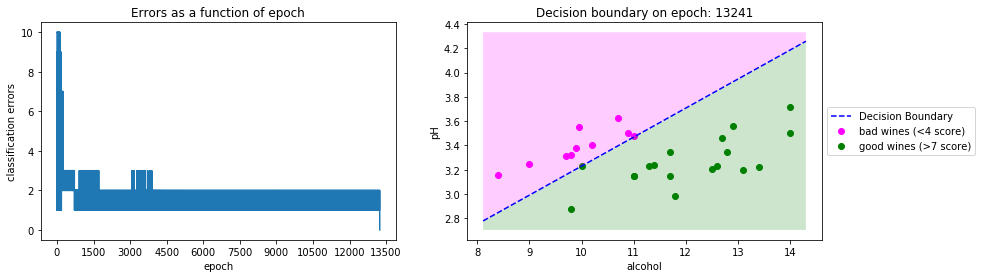

In [18]:
plot_performance(performance, df, 8, 3, epoch=-1)

### d) Your perceptron appears to work. . . but why is it taking so many epochs to train?
Maybe you can modify the red wine data to help the perceptron learn more quickly?
Use the function you just created in part c) to plot and verify that your
perceptron is learning more efficiently!

In [19]:
def get_mean(serie):
    nums = serie.tolist()
    result = 0
    for x in nums:
        result += x
    return result / len(nums)

def get_std(serie):
    nums = serie.tolist()
    n = len(nums)
    mean = get_mean(serie)
    f = sum((x - mean) ** 2 for x in nums)
    v = f / (n - 1)
    return v ** 0.5
    
def feature_scale_std(data_old):
    data = data_old.copy(deep = True)
    for column in data:
        if column == 'quality' or column == 'is good':
            break
        get_mean(data[column])
        data_mean = get_mean(data[column])
        data_std = get_std(data[column])
        data[column] = data[column].apply(lambda x: (x - data_mean) / data_std)
    return (data)

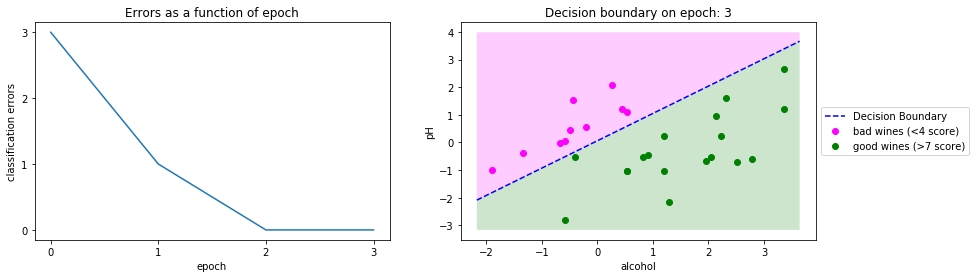

In [20]:
random.seed(4242)
df_scaled = feature_scale_std(df)
training_data, expected = get_training_lists(df_scaled, 8, 3)
performance = ppn.train(training_data, expected, epochs = 0, learning_rate = 0.1)
plot_performance(performance, df_scaled, 8, 3)

# V.3 My fair ADALINE

Encouraged by the results of your perceptron, you decide to see if you can use it to
distinguish between wines with a score of 4 and lower, and wines with a score
of 7 and higher. Feeling confident, you decide to let the perceptron train until it can
find the best decision boundary.
### a) Marvin notices and chides you for torturing your perceptron. Why?

Perceptrons are great at handling data which does not "overlap". If we look at the graph above, then what happens to the decision boundary if a bad wine is placed in the green zone? If there ends up being no orientation where the decision boundary seperates all bad and good wines, then the perceptron cannot be trained to come up with weights that produce no wrong answers. It will keep attempting to change its weights if it notices an error.

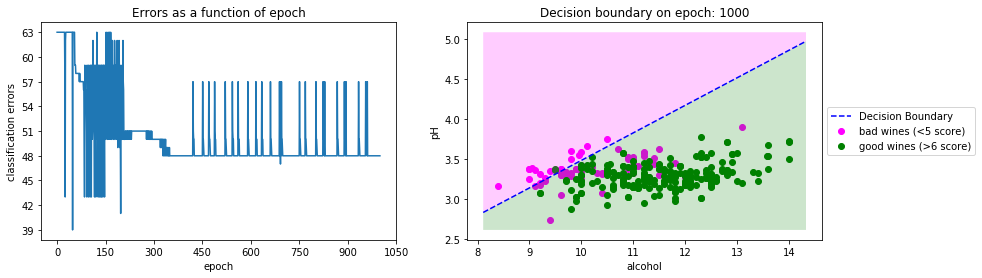

In [21]:
random.seed(4242)
training_data, expected = get_training_lists(df, 7, 4)
performance = ppn.train(training_data, expected, epochs = 1000, learning_rate = 0.1)
plot_performance(performance, df, 7, 4)

Here you can clearly how intertwined the good and bad wines are. Also, as a feature scaled data set:

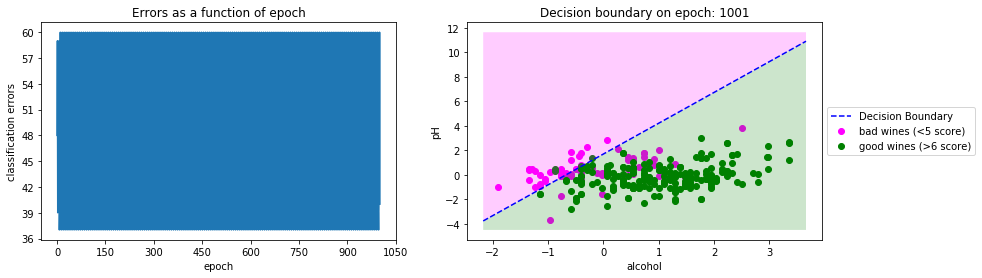

In [22]:
random.seed(4242)
training_data, expected = get_training_lists(df_scaled, 7, 4)
performance = ppn.train(training_data, expected, epochs = 1001, learning_rate = 0.1)
plot_performance(performance, df_scaled, 7, 4)

Here you can very much see the problem that the learning algorithm has, where it will try to update its weights when it encounters an error.

### b) Implement an ADALINE that:
• Has randomly initialized weights and bias  
• Uses a linear activation function and some kind of quantizer  
• Uses the Widrow-Hoff learning rule  

### c) You’ll need to implement a function to train your ADALINE. Your training function should:  
• Take in your red wine data as a parameter  
• Have a way to specify number of training epochs  
• If training epochs is set to 0, your ADALINE should train until it converges on a good set of weights.  
• Have a way to specify learning rate.  
• Have an option to perform either online learning or batch learning  

In [23]:
def list_sum(X):
    result = 0
    for n in X:
        result += n
    return result

def array_column(arr, i):
    return [row[i] for row in arr]

class Adaline(object):
    
    def __init__(self, weights = 0):
        if weights == 0:
            self.weights = []
        else:
            self.weights = [random.uniform(-1.0, 1.0) for _ in range(weights)]
        self.bias = 0
    
    def train(self, wine_data, expected_result, learning_rate = 0.01, epochs = 0, online = False, reset = True):  
        if reset:
            self.weights = [random.uniform(-1.0, 1.0) for _ in range(wine_data.shape[1])]
            self.bias = random.uniform(-1.0, 1.0)
        
        performance_list = []
        current_epoch = 0
        cost = 0
        
        while True:
            performance = []
            performance.append(current_epoch)
            
            old_cost = cost
            
            if online:
                for xi, target in zip(wine_data, expected_result):
                    output = self.get_output(xi)
                    error = (target - output)
                    for i in range(0, len(xi)):
                        xz = xi[i]
                        self.weights[i] += learning_rate * error * xz
                    self.bias += learning_rate * error
            
                cost = 0
                for i in range(0, len(expected_result)):
                    cost += ((expected_result[i] - self.get_output(wine_data[i]))**2)
                cost /= 2.0
            else:
                outputs = []
                for x in wine_data:
                    outputs.append(self.get_output(x))
                errors = []
                for i in range(0, len(expected_result)):
                    errors.append(expected_result[i] - outputs[i])
                for i in range(0, len(self.weights)):
                    self.weights[i] += learning_rate * dot_product(array_column(wine_data, i), errors)
                self.bias += learning_rate * list_sum(errors)
                for i in range(0, len(errors)):
                    errors[i] = errors[i] ** 2
                cost = list_sum(errors) / 2.0
            
            performance.append(self.classification_errors(wine_data, expected_result))
            performance.append(copy.deepcopy(self.weights))
            performance.append(self.bias)
            performance_list.append(performance)
            
            if epochs != 0:
                if current_epoch == epochs:
                    break
            else:
                if abs(cost - old_cost) < 0.0001:
                    break
            current_epoch += 1
        return performance_list
    
    def get_output(self, wine_data, tanh = False):
        if tanh:
            return math.tanh(dot_product(wine_data, self.weights) + self.bias)
        else:
            return dot_product(wine_data, self.weights) + self.bias
    
    def predict(self, wine_data):
        return 1 if self.get_output(wine_data) >= 0.0 else -1
    
    def classification_errors(self, wine_data, expected_result):
        errors = 0
        for data, target in zip(wine_data, expected_result):
            if self.predict(data) != target:
                errors += 1
        return errors

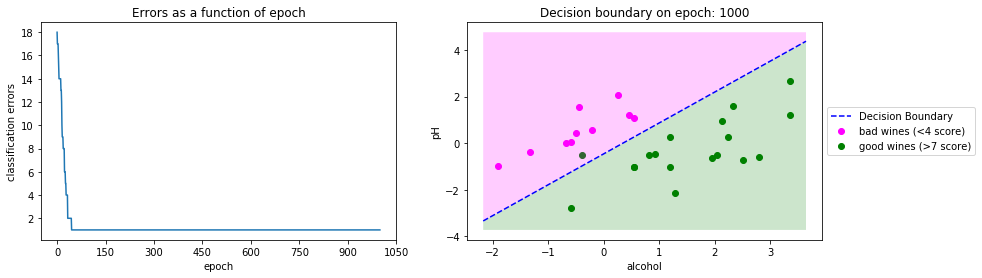

In [24]:
random.seed(4242)
training_data, expected = get_training_lists(df_scaled, 8, 3)
ada = Adaline()
performance = ada.train(training_data, expected, epochs = 1000, learning_rate = 0.001, online = False, reset = True)
plot_performance(performance, df_scaled, 8, 3)

### d) Find a good learning rate for your ADALINE and plot number of classification errors vs. epoch and the decision boundary of your ADALINE. What setting tend to give the smallest number of classification errors? Support your reasoning with example plots!

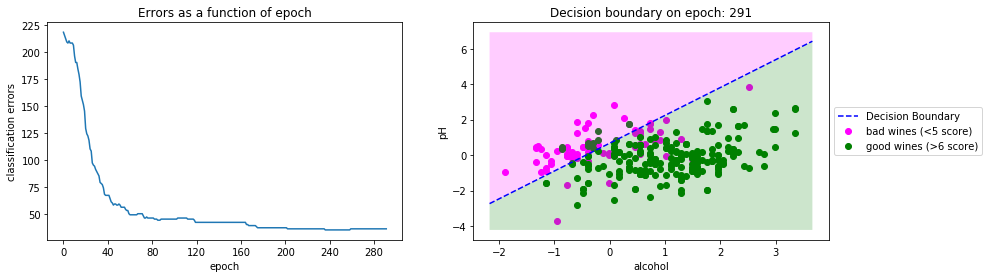

final epoch for learning_rate = 0.0001:  [291, 36, [-0.2919535043608477, 0.45814659559013654], 0.19612433796767273]


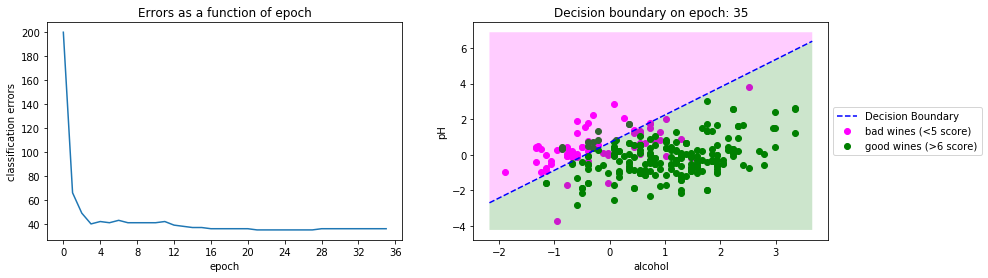

final epoch for learning_rate = 0.001:  [35, 36, [-0.2911031570460668, 0.4523842426453429], 0.19801794419747948]


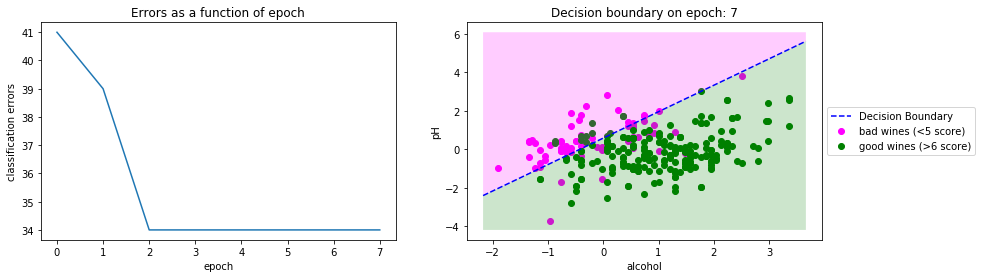

final epoch for learning_rate = 0.01:  [7, 34, [-0.31277269933277607, 0.4293766637917851], 0.1828410250937666]


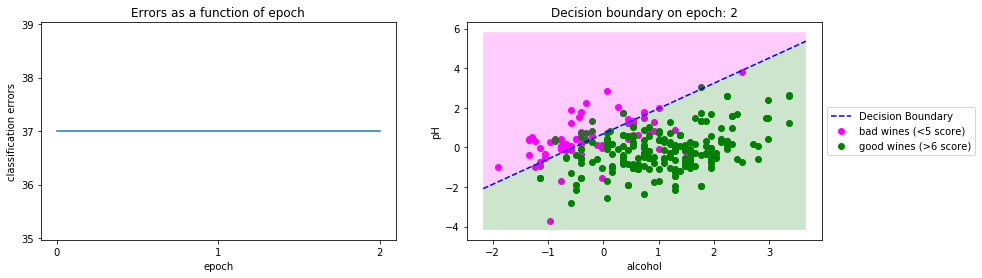

final epoch for learning_rate = 0.05:  [2, 37, [-0.4226831241686241, 0.5395349384248208], 0.29131168979029587]


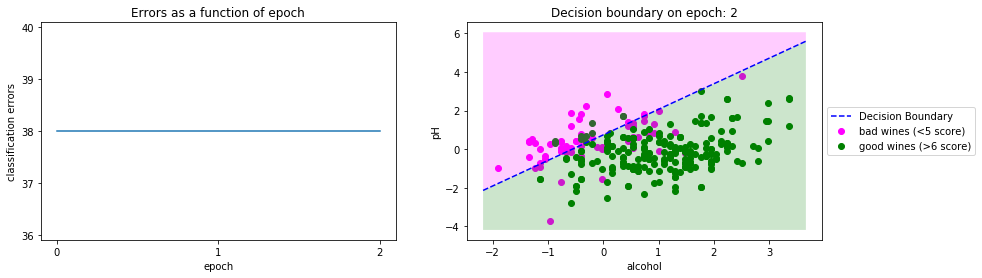

final epoch for learning_rate = 0.06:  [2, 38, [-0.4230703522080054, 0.5602679247694948], 0.3148073387164585]


In [25]:
random.seed(4242)
training_data, expected = get_training_lists(df_scaled, 7, 4)

performance = ada.train(training_data, expected, epochs = 0, learning_rate = 0.0001, online = True)
plot_performance(performance, df_scaled, 7, 4)
print('final epoch for learning_rate = 0.0001: ', performance[-1])

performance = ada.train(training_data, expected, epochs = 0, learning_rate = 0.001, online = True)
plot_performance(performance, df_scaled, 7, 4)
print('final epoch for learning_rate = 0.001: ', performance[-1])

performance = ada.train(training_data, expected, epochs = 0, learning_rate = 0.01, online = True)
plot_performance(performance, df_scaled, 7, 4)
print('final epoch for learning_rate = 0.01: ', performance[-1])

performance = ada.train(training_data, expected, epochs = 0, learning_rate = 0.05, online = True)
plot_performance(performance, df_scaled, 7, 4)
print('final epoch for learning_rate = 0.05: ', performance[-1])

performance = ada.train(training_data, expected, epochs = 0, learning_rate = 0.06, online = True)
plot_performance(performance, df_scaled, 7, 4)
print('final epoch for learning_rate = 0.06: ', performance[-1])

These are the results for online training. For batch training we get:

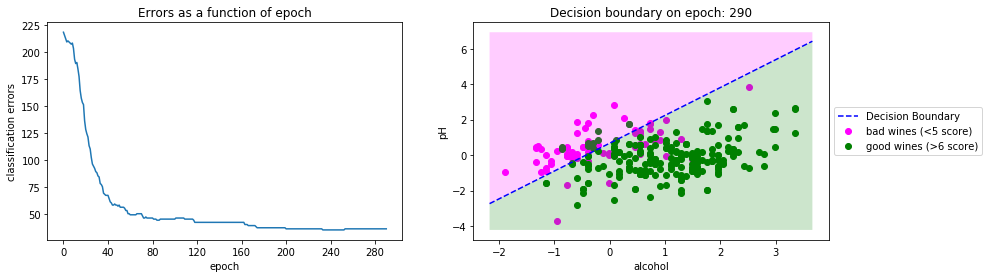

final epoch for learning_rate = 0.0001:  [290, 36, [-0.29196113166802634, 0.458386618812513], 0.1964814595952394]


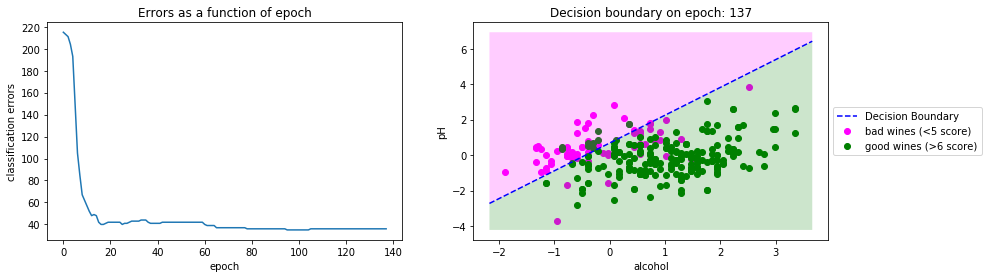

final epoch for learning_rate = 0.0002:  [137, 36, [-0.2915473408768113, 0.45710123314564777], 0.1983827784476107]


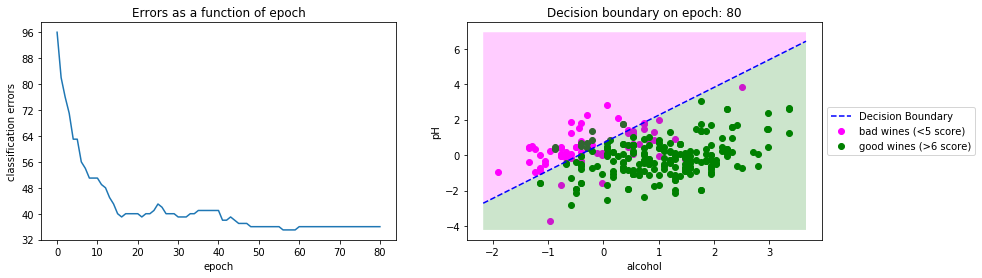

final epoch for learning_rate = 0.0005:  [80, 36, [-0.2911349608294314, 0.45591752438524236], 0.20012294819514798]


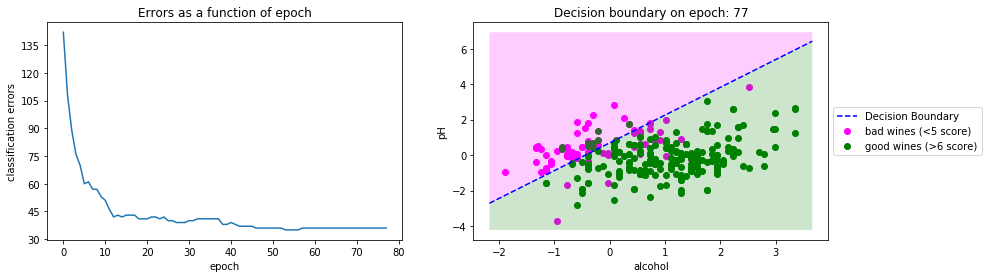

final epoch for learning_rate = 0.001:  [77, 36, [-0.29114458630121204, 0.4559443125669441], 0.20008366851925272]


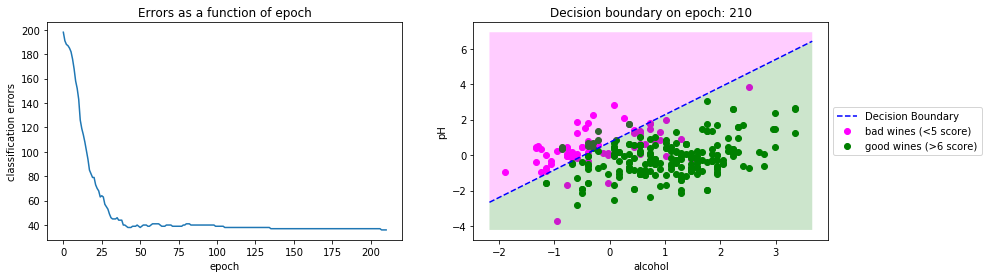

final epoch for learning_rate = 0.005:  [210, 36, [-0.2893053235620773, 0.4503743701196208], 0.20830278995654278]


In [26]:
random.seed(4242)

performance = ada.train(training_data, expected, epochs = 0, learning_rate = 0.0001, online = False)
plot_performance(performance, df_scaled, 7, 4)
print('final epoch for learning_rate = 0.0001: ', performance[-1])

performance = ada.train(training_data, expected, epochs = 0, learning_rate = 0.0002, online = False)
plot_performance(performance, df_scaled, 7, 4)
print('final epoch for learning_rate = 0.0002: ', performance[-1])

performance = ada.train(training_data, expected, epochs = 0, learning_rate = 0.0005, online = False)
plot_performance(performance, df_scaled, 7, 4)
print('final epoch for learning_rate = 0.0005: ', performance[-1])

performance = ada.train(training_data, expected, epochs = 0, learning_rate = 0.0005, online = False)
plot_performance(performance, df_scaled, 7, 4)
print('final epoch for learning_rate = 0.001: ', performance[-1])

performance = ada.train(training_data, expected, epochs = 0, learning_rate = 0.0001, online = False)
plot_performance(performance, df_scaled, 7, 4)
print('final epoch for learning_rate = 0.005: ', performance[-1])

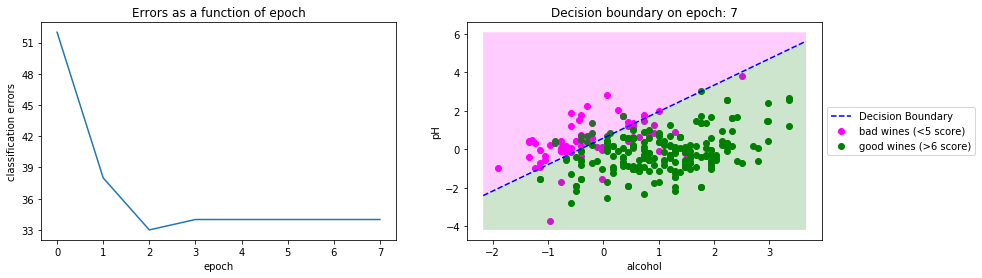

final epoch for learning_rate = 0.01:  [7, 34, [-0.31277038426702414, 0.42936042522210477], 0.18286286850821562]


In [27]:
performance = ada.train(training_data, expected, epochs = 0, learning_rate = 0.01, online = True)
plot_performance(performance, df_scaled, 7, 4)
print('final epoch for learning_rate = 0.01: ', performance[-1])

Batch training seems to have higher accuracy than online training when dealing with any learning rate. When a high learning rate gets applied to a ADALINE which trains by online training it starts to display inaccuracies as it diverges, while batch training always finds the correct local minimum. Online training is faster though, being able to find the minimum after 6 epochs, while batch training has taken a minimum of 20. The best of the bunch was online training with a fairly high training rate as you can see above.

# V.4 Advanced wine sampling and resampling

### a) Write a function that uses the holdout method to partition the red wine data into a training and a validation set

In [28]:
def holdout(wine_data, training_ratio = 0.8):
    data = wine_data.copy(deep = True)
    data = data.sample(frac = 1)
    trains = math.floor(data.shape[0] * training_ratio)
    tests = data.shape[0] - trains
    train = data.head(trains)
    test = data.tail(tests)
    return train, test

Let us also do some training and validation with this for funsies.

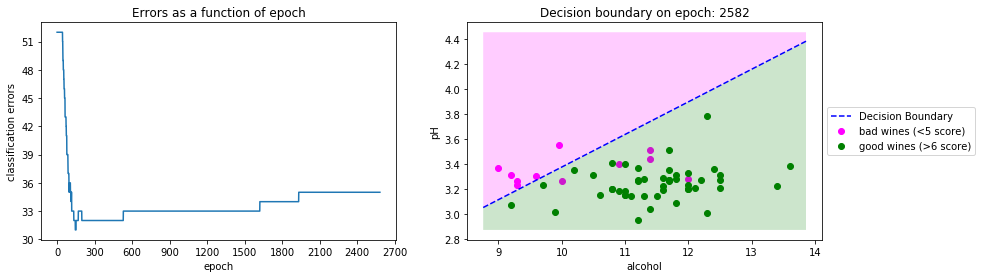

In [29]:
df = pd.read_csv('winequality-red.csv', sep = ';')
train, test = holdout(df, training_ratio = 0.8)
train, train_expected = get_training_lists(train, 7, 4)
performance = ada.train(train, train_expected, epochs = 0, learning_rate = 0.001, online = True)
plot_performance(performance, test, 7, 4)

### b) Write a function that generate a k-fold cross-validation dataset from the red wine data

In [30]:
def kfold(wine_data, k = 10, shuffle = False):
    data = wine_data.copy(deep = True)
    if shuffle:
        data = data.sample(frac = 1)
    train_list = []
    test_list = []
    folds = []
    inc = math.floor(len(data) / k)
    tcur = 0
    current = 0
    for i in range(0, k):
        if shuffle:
            data = data.sample(frac = 1)
        current = math.floor(tcur)
        upper = tcur + inc
        if i < len(data) % k:
            upper += 1
        test = data[current:upper]
        train = pd.concat([data[:current], data[upper:]])
        f = train, test
        folds.append(f)
        tcur += inc
    return folds

It is harder to show that this one works, so this will be reserved for the next exercise

### c) What effects does changing learning rate and number of training epochs have on the ADALINE when evaluated via k-fold cross-validation?

In [31]:
def ada_trained_with_kfold(wine_data, good_thresh, bad_thresh, learning_rate = 0.001, epochs = 0, online = True, shuff = False):
    folds = kfold(wine_data, k = 10, shuffle = shuff)
    ada = Adaline(weights = 2)
    performance = []
    epoch_list = []
    for x, y in folds:
        train_t, train_e = get_training_lists(x, good_thresh, bad_thresh)
        performance = ada.train(train_t, train_e, learning_rate, epochs, online, reset = False)
        epoch_list.append(performance)
    total_performance = []
    for x in epoch_list:
        total_performance.extend(x)
    plot_performance(total_performance, wine_data, good_thresh, bad_thresh)
    return (epoch_list)

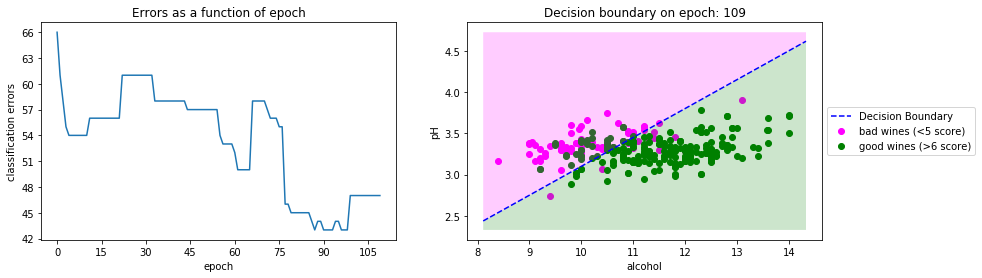

In [32]:
epoch_list = ada_trained_with_kfold(df, 7, 4, epochs = 10, learning_rate = 0.001)

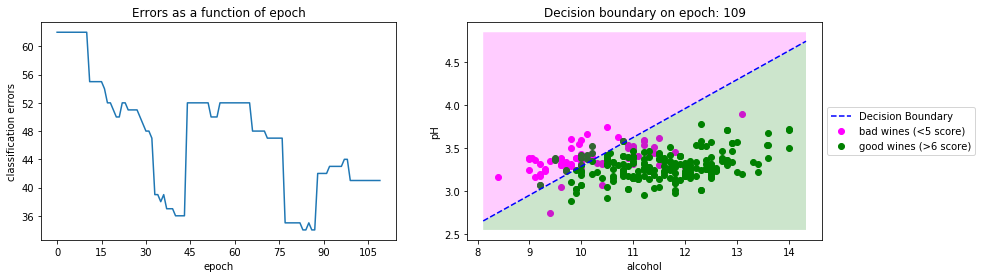

In [33]:
epoch_list = ada_trained_with_kfold(df, 7, 4, epochs = 10, learning_rate = 0.001, shuff = True)

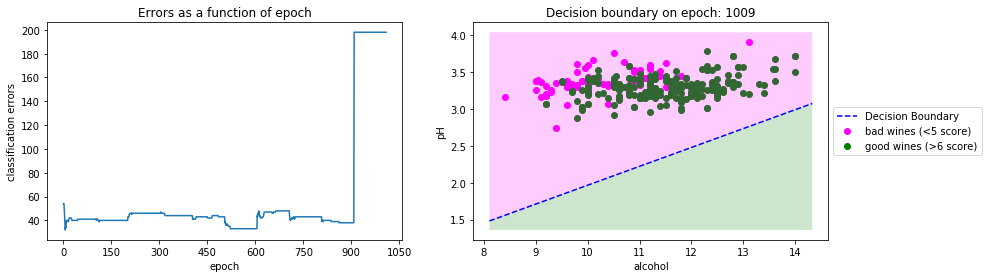

In [34]:
epoch_list = ada_trained_with_kfold(df, 7, 4, epochs = 100, learning_rate = 0.01)

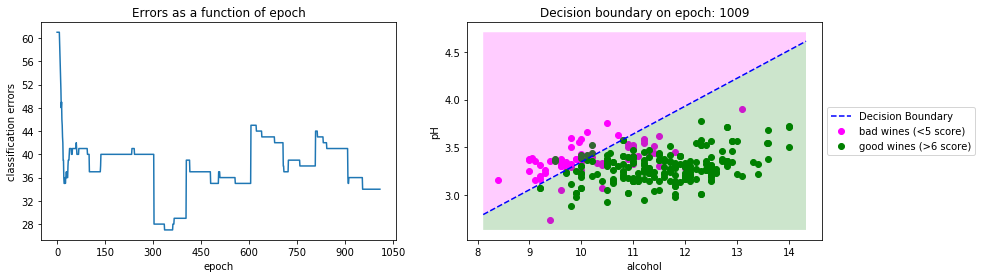

In [35]:
epoch_list = ada_trained_with_kfold(df, 7, 4, epochs = 100, learning_rate = 0.001, shuff = True)

It seems to be a good idea to train the network with relatively few epochs and with a lowish learning rate, otherwise it will be overfitted for each fold and will not adapt as smoothly.

# V.5 Adventures in the Nth dimension

### a) Try training your perceptron/ADALINE with different numbers and types of chemical factors. Under what circumstances can your perceptron/ADALINE successfully train?

In [36]:
def get_training_lists_v2(wine_data, good_thresh, bad_thresh, datas = [8, 10], good_col = 12):
    wine_data = get_training_data(wine_data, good_thresh, bad_thresh)
    expected_result = wine_data.iloc[1:wine_data.shape[0], good_col].values
    wine_data_training = wine_data.iloc[1:wine_data.shape[0], datas].values
    return wine_data_training, expected_result

In [37]:
import itertools
          
def cool_bar():
    min_errors = 10000
    best_performance = []
    curr_params = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    best_performance_per_i = []
    best_performance_curr = []
    for i in range(1, len(curr_params) + 1):
        min_errors_curr = 10000
        for subset in itertools.combinations(curr_params, i):
            varss = list(subset)
            training_data, expected = get_training_lists_v2(df_scaled, 8, 3, datas = varss)
            performance = ada.train(training_data, expected, epochs = 0, learning_rate = 0.001, online = True, reset = True)
            print(varss)
            print(performance[-1])
            print('\n')
            if performance[-1][1] < min_errors_curr:
                min_errors_curr = performance[-1][1]
                best_performance_curr = performance[-1]
                best_performance_curr.append(varss)
            if performance[-1][1] < min_errors:
                min_errors = performance[-1][1]
                best_performance = performance[-1]
                best_performance.append(varss)
        best_performance_per_i.append(best_performance_curr)
    for i in range(1, 11 + 1):
        print("Best performance at ", i, " parameters: ", best_performance_per_i[i - 1], '\n')
    print("Best performance total: ", best_performance)
            
cool_bar()

[0]
[162, 10, [0.05300686998433797], 0.24059188109988994]


[1]
[149, 4, [-0.38751072330667685], 0.39614675794257637]


[2]
[146, 6, [0.34452405551319565], 0.20673806592351318]


[3]
[161, 10, [-0.0346320304463248], 0.2534522522637072]


[4]
[88, 6, [-0.5442453536720699], 0.2618748616476883]


[5]
[141, 10, [0.10857614295144041], 0.2968042075590592]


[6]
[324, 10, [0.27514725492232356], 0.40013332999798973]


[7]
[173, 8, [-0.34038942370295167], 0.1272530496171991]


[8]
[128, 10, [-0.2685197899611798], 0.2494939872334735]


[9]
[206, 3, [0.6868495604479944], 0.12789240192134957]


[10]
[64, 5, [0.4722362323505372], -0.11141808890204986]


[0, 1]
[209, 5, [-0.17738932402929755, -0.4278097838041216], 0.43309657562601717]


[0, 2]
[561, 3, [-0.842777983592257, 0.9942471564886148], 0.16844305264067205]


[0, 3]
[193, 10, [0.05744865087976969, -0.05147710646693796], 0.25132070881328394]


[0, 4]
[168, 6, [0.10032267736991896, -0.5457327353072453], 0.24367616181172444]


[0, 5]
[93, 10, [0

KeyboardInterrupt: 

The ADALINE trains best with fixed acidity, volatile acidity, pH and alcohol.

### b) You know what the decision boundary for 2 wine chemical factors looks like, but what does the decision boundary for 3 factors look like? What about if you use 7 factors? How about if you use all 11 wine chemical factors?

2 chemical factors = line (1d object)  
3 chemical factors = plane (2d object)  
4 chemical factors = cube (3d object)  
5 chemical factors = tesseract (4d object)  
11 chemical factors = 10-dimensional hypercube (10d object)

The pattern continues as so. The decision boundary of n chemical factors will be a geometric object of n - 1 dimensions.

# V.6 Marvin's rebuttal

### a) While not a wine... find a way to successfully classify the Pan-Galactic Gargle Blaster dataset. Show that your perceptron or ADALINE successfully classifies the Pan-Galactic Gargle Blaster data set by plotting the decision boundary and also show 'good' and 'bad' Gargle Blaster data points.

Let us first see how the Pan Galactic Gargle Blaster dataset looks like in a scatter matrix.

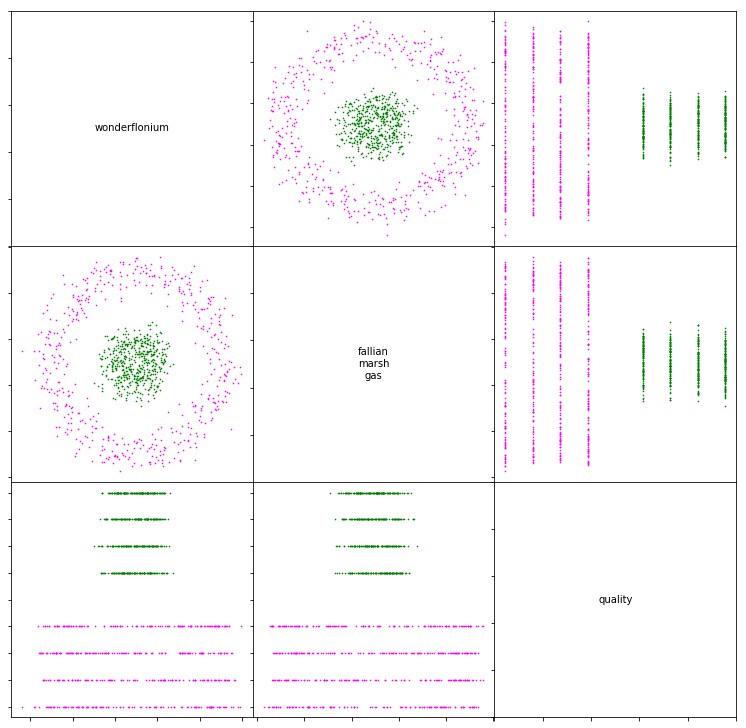

In [38]:
df = pd.read_csv('Pan Galactic Gargle Blaster.csv', sep = ';')
plot_scatter_matrix(df, 6, 5, False)

This does not look similar to the structure of our wine data, but maybe the genius ADALINE function will do some crazy things and will learn how to differentiate good and bad magically.

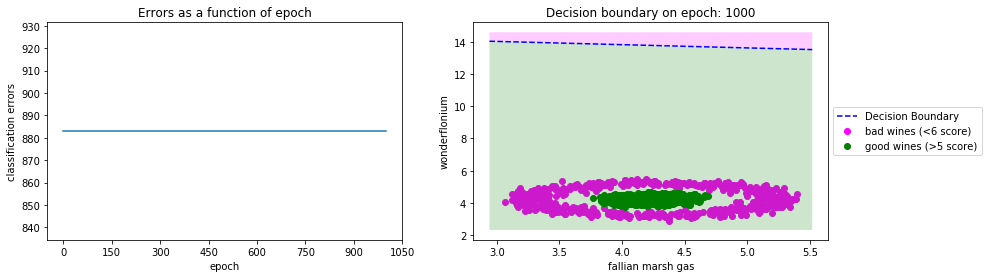

In [40]:
training_data, expected = get_training_lists_v2(df, 6, 5, datas = [0, 1], good_col = 2)
performance = ada.train(training_data, expected, epochs = 1000, online = True, learning_rate = 0.01)
plot_performance(performance, df, 6, 5, datas=[0, 1])

Uh oh! The network does not seem to like this!

While there is an obvious seperation between the good and bad, the dataset is not linearly seperable, and therefore impossible for a perceptron/ADALINE to classify the data 100% of the time. Some data transformation is required to make it possible. Let us first scale the data to keep the center of the scatter at origin.

In [41]:
df_scaled = feature_scale_std(df)

Now let us take the radial basis of each row and add that to a new column called center dist (distance from origin)

In [42]:
def radial_basis(data_old):
    data = data_old.copy(deep = True)
    data['center dist'] = data.apply(lambda row: math.sqrt(row['wonderflonium'] ** 2 + row['fallian marsh gas'] ** 2), axis = 1)
    data = data[['wonderflonium', 'fallian marsh gas', 'center dist', 'quality']]
    return data

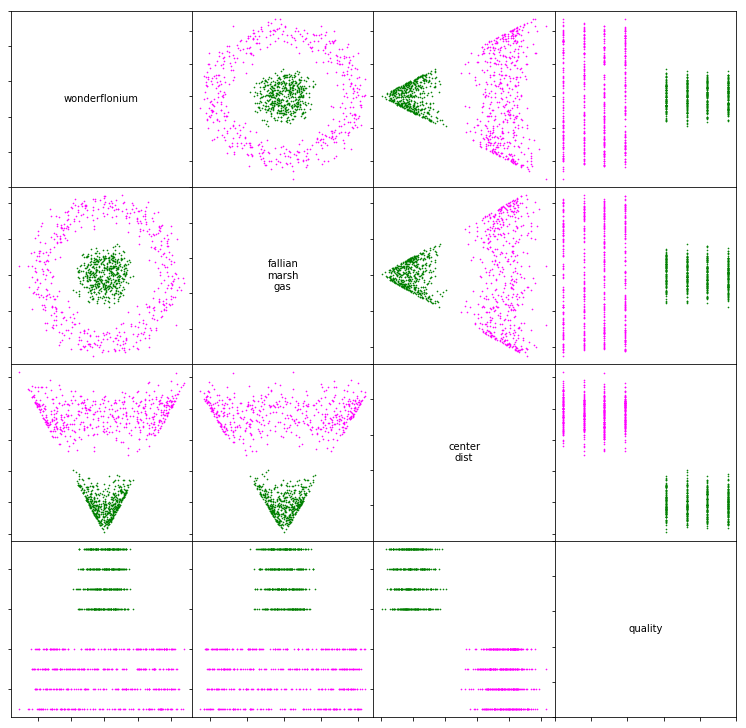

In [43]:
rdata = radial_basis(df_scaled)
plot_scatter_matrix(rdata, 6, 5, False)

Now we have two linearly seperatable graphs (wonderflonium and center dist, fallian marsh gas and center dist), and we can use that to train a perceptron until no errors.

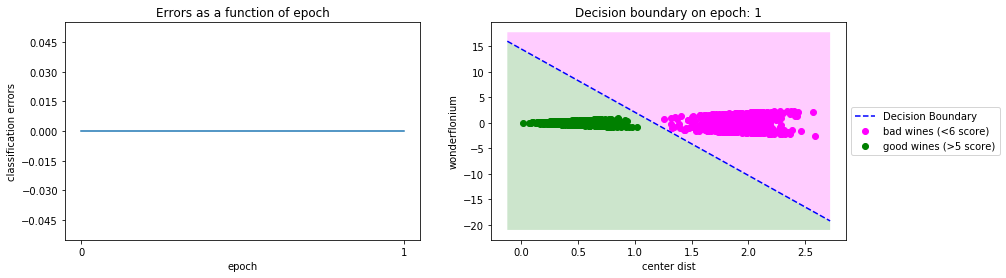

In [44]:
training_data, expected = get_training_lists_v2(rdata, 6, 5, datas = [0, 2], good_col = 4)
performance = ppn.train(training_data, expected, epochs = 0, learning_rate = 0.1)
plot_performance(performance, rdata, 6, 5, datas = [0, 2])

# Bonus Part  

# VI.1 Gotta go fast!

Write (or maybe rewrite!) your perceptron and ADALINE algorithm functions as Cython functions!

In [45]:
%load_ext cython

In [46]:
%%cython
from libc.stdlib cimport malloc, free, rand, srand, RAND_MAX
from cpython cimport array
import array
import pandas as pd
import random

srand(0)

cdef struct s_perceptron:
    float *weights;
    float bias;
    int n_weights;
ctypedef s_perceptron t_perceptron

# Utility

cdef get_mean(serie):
    nums = serie.tolist()
    result = 0
    for x in nums:
        result += x
    return result / len(nums)

cdef get_std(serie):
    nums = serie.tolist()
    n = len(nums)
    mean = get_mean(serie)
    f = sum((x - mean) ** 2 for x in nums)
    v = f / (n - 1)
    return v ** 0.5
    
cdef feature_scale_std(data_old):
    data = data_old.copy(deep = True)
    for column in data:
        if column == 'quality' or column == 'is good':
            break
        get_mean(data[column])
        data_mean = get_mean(data[column])
        data_std = get_std(data[column])
        data[column] = data[column].apply(lambda x: (x - data_mean) / data_std)
    return (data)

cdef get_training_data(wine_data, good_threshold, bad_threshold): # error is here somewhere
    data = wine_data[(wine_data.quality >= good_threshold) | (wine_data.quality <= bad_threshold)]
    data = data.copy(deep = True)
    good_list = []
    for index, row in data.iterrows():
        good_list.append(1 if row['quality'] >= good_threshold else -1)
    data['is good'] = good_list
    return data

cdef get_training_lists(wine_data, good_thresh, bad_thresh):
    wine_data = get_training_data(wine_data, good_thresh, bad_thresh)
    expected_result = wine_data.iloc[1:wine_data.shape[0], 12].values
    wine_data_training = wine_data.iloc[1:wine_data.shape[0], [8, 10]].values
    return wine_data_training, expected_result

cdef float c_dot_product(x, y):
    cdef float result = 0
    for i in range(len(x)):
        result += x[i] * y[i]
    return result

cdef float per_predict(t_perceptron per, wine_data):
    weights = []
    for i in range(per.n_weights):
        weights.append(per.weights[i])
    return (1 if c_dot_product(wine_data, weights) + per.bias >= 0.0 else -1)

cdef float per_output(t_perceptron per, wine_data):
    weights = []
    for i in range(per.n_weights):
        weights.append(per.weights[i])
    return (c_dot_product(wine_data, weights) + per.bias)

cdef array_column(arr, i):
    return [row[i] for row in arr]

cdef list_sum(X):
    result = 0
    for n in X:
        result += n
    return result

# Perceptron

cdef t_perceptron per_init(int weights):
    cdef t_perceptron per;
    per.n_weights = weights;
    per.weights = <float *> malloc(sizeof(float) * weights);
    for i in range(weights):
        per.weights[i] = <float>rand() / <float>RAND_MAX;
    per.bias = <float>rand() / <float>RAND_MAX;
    return per;

cdef int per_errors(t_perceptron per, wine_data, expected_result):
    cdef int errors = 0
    for data, target in zip(wine_data, expected_result):
        if per_predict(per, data) != target:
            errors += 1
    return errors

cdef per_train(t_perceptron *per, wine_data, expected_result, float learning_rate = 0.1, int epochs = 0):
    performance_list = []
    cdef int current_epoch = 0
    
    while True:
        performance = []
        performance.append(current_epoch)
        errors = 0
        
        for xi, target in zip(wine_data, expected_result):
            update = learning_rate * (target - per_predict(per[0], xi))
            for i in range(per.n_weights):
                per.weights[i] += update * xi[i]
            per.bias += update
            errors += <int>(update != 0.0)    
        
        performance.append(per_errors(per[0], wine_data, expected_result))
        curr_weights = []
        for i in range(per.n_weights):
            curr_weights.append(per.weights[i])
        performance.append(curr_weights)
        performance.append(per.bias)
        performance_list.append(performance)
        
        if epochs != 0:
            if current_epoch == epochs:
                break
        else:
            if errors == 0:
                break
        current_epoch += 1
    return performance_list

# Adaline

cdef ada_train(t_perceptron *per, wine_data, expected_result, float learning_rate = 0.01, int epochs = 0, int online = False, int reset = True):
    performance_list = []
    if reset:
        for i in range(per.n_weights):
            per.weights[i] = <float>rand() / <float>RAND_MAX
        per.bias = <float>rand() / <float>RAND_MAX
    
    cdef int current_epoch = 0
    cdef float cost = 0
    
    while True:
        performance = []
        performance.append(current_epoch)
        
        old_cost = cost
        
        if online:
            for xi, target in zip(wine_data, expected_result):
                output = per_output(per[0], xi)
                error = (target - output)
                for i in range(len(xi)):
                    xz = xi[i]
                    per.weights[i] += learning_rate * error * xz
                per.bias += learning_rate * error
            
            cost = 0
            for i in range(len(expected_result)):
                cost += ((expected_result[i] - per_output(per[0], wine_data[i]))**2)
            cost /= 2.0
        else:
            outputs = []
            for x in wine_data:
                outputs.append(per_output(per[0], wine_data[i]))
            errors = []
            for i in range(len(expected_result)):
                errors.append(expected_result[i] - outputs[i])
            for i in range(per.n_weights):
                per.weights[i] += learning_rate * c_dot_product(array_column(wine_data, i), errors)
            per.bias += learning_rate * list_sum(errors)
            for i in range(len(errors)):
                errors[i] = errors[i] ** 2
            cost = list_sum(errors) / 2.0
        
        performance.append(per_errors(per[0], wine_data, expected_result))
        curr_weights = []
        for i in range(per.n_weights):
            curr_weights.append(per.weights[i])
        performance.append(curr_weights)
        performance.append(per.bias)
        performance_list.append(performance)
        
        if epochs != 0:
            if current_epoch == epochs:
                break
        else:
            if abs(cost - old_cost) < 0.0001:
                break
        current_epoch += 1
    return performance_list
            
cdef t_perceptron per = per_init(2)
random.seed(4242)
df = pd.read_csv('winequality-red.csv', sep = ';')
training_data, expected = get_training_lists(df, 8, 3)
performance = ada_train(&per, training_data, expected, learning_rate = 0.001, epochs = 0, online = True)
for p in performance:
    print(p)
free(per.weights)

[0, 13, [0.4952620565891266, -0.13229189813137054], 0.10585730522871017]
[1, 21, [0.4796679615974426, -0.14559443295001984], 0.10176215320825577]
[2, 21, [0.4687493145465851, -0.14234566688537598], 0.09908978641033173]
[3, 21, [0.45795780420303345, -0.13884782791137695], 0.09645477682352066]
[4, 21, [0.4472200870513916, -0.13536296784877777], 0.093834787607193]
[5, 20, [0.43653467297554016, -0.13189516961574554], 0.09122935682535172]
[6, 20, [0.4259013235569, -0.12844443321228027], 0.08863840997219086]
[7, 20, [0.4153198301792145, -0.1250106692314148], 0.08606190979480743]
[8, 20, [0.4047899842262268, -0.12159384787082672], 0.08349976688623428]
[9, 20, [0.3943113386631012, -0.11819380521774292], 0.08095189183950424]
[10, 20, [0.3838837742805481, -0.11481048166751862], 0.07841822504997253]
[11, 20, [0.3735070526599884, -0.11144382506608963], 0.07589872181415558]
[12, 20, [0.363180935382843, -0.1080937460064888], 0.07339327782392502]
[13, 20, [0.3529050350189209, -0.10476014018058777], 0

# VI.2 Do perceptrons dream of electric sheep?

Create animated plots of error as a function and the changing decision boundary of your perceptron and/or ADALINE as a function of epoch. Each time step in your animation should be equvalent to advancing the training epoch by 1!

In [47]:
random.seed(4242)

df = pd.read_csv('winequality-red.csv', sep = ';')
training_data, expected = get_training_lists_v2(df, 8, 3)
performance = ppn.train(training_data, expected, epochs = 0, learning_rate = 0.1)

<Figure size 1008x288 with 0 Axes>

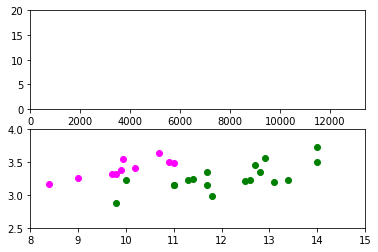

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, clear_output

plt.figure(figsize=(14, 4))

fig, (ax, dx) = plt.subplots(2, 1)
line, = ax.plot([], [], lw=2)
db, = dx.plot([], [], c = 'blue', label = 'Decision Boundary', linestyle = 'dashed')
lines = [line, db]

ax.set_xlim((0, performance[-1][0]))
ax.set_ylim((0, 20))

dx.set_xlim(8, 15)
dx.set_ylim(2.5, 4)

xmin, xmax = 8, 15
ymin, ymax = 2.5, 4

def init():
    good_wines = df.loc[df['quality'] >= 8]
    bad_wines = df.loc[df['quality'] <= 3]
    
    alcohol = bad_wines.iloc[0:bad_wines.shape[0], 10].values
    ph = bad_wines.iloc[0:bad_wines.shape[0], 8].values
    current_label = 'bad wines (<' + str(4) + ' score)'
    dx.scatter(alcohol, ph, c = 'magenta', label = current_label)
    
    alcohol = good_wines.iloc[0:good_wines.shape[0], 10].values
    ph = good_wines.iloc[0:good_wines.shape[0], 8].values
    current_label = 'good wines (>' + str(7) + ' score)'
    dx.scatter(alcohol, ph, c = 'green', label = current_label)
    
    lines[0].set_data([], [])
    lines[1].set_data([], [])
    return lines

def animate(i):
    clear_output(wait=True)
    print(i, '/', performance[-1][0])
    xd = [x[0] for x in performance[:i]]
    yd = [x[1] for x in performance[:i]]
    lines[0].set_data(xd, yd)
    
    b = float(performance[i][3])
    w1 = float(performance[i][2][0])
    w2 = float(performance[i][2][1])
    
    print([w1, w2], b)
    
    py = []
    py.append((-(b / w1) / (b / w2)) * xmin + (-b / w1))
    py.append((-(b / w1) / (b / w2)) * xmax + (-b / w1))
    px = [xmin, xmax]
    
    lines[1].set_data(px, py)
    return lines

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=performance[-1][0], interval=1, blit=False)

In [49]:
HTML(anim.to_html5_video())

13395 / 13396
[-144.9350983693618, 34.611387447293836] 122.05690270091095


# VI.3 Dimensional traveler

In [50]:
from mpl_toolkits.mplot3d import Axes3D

def linspace(beg, end, n):
    result = []
    step = (end - beg) / (n - 1)
    for i in range(n):
        result.append(beg + step * i)
    return result

def meshgrid(x, y):
    XX, YY = [], []
    for i in range(len(y)):
        XX.append(copy.deepcopy(x))
    for i in range(len(y)):
        Y = []
        for j in range(len(x)):
            Y.append(y[i])
        YY.append(copy.deepcopy(Y))
    return XX, YY

def flatten(x):
    result = []
    for i in x:
        result = result + i
    return result

def plot_decision_boundary_3D(performance, wine_data, good_thresh, bad_thresh, epoch=-1, datas = [1, 8, 10]):
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    good_wines = wine_data.loc[wine_data['quality'] >= good_thresh]
    bad_wines = wine_data.loc[wine_data['quality'] <= bad_thresh]
    
    d1 = bad_wines.iloc[0:bad_wines.shape[0], datas[0]].values
    d2 = bad_wines.iloc[0:bad_wines.shape[0], datas[1]].values
    d3 = bad_wines.iloc[0:bad_wines.shape[0], datas[2]].values
    lb = 'bad wines (<' + str(bad_thresh + 1) + ' score)'
    ax.scatter(d1, d2, d3, c = 'magenta', marker='^', label = lb, s=100)
    
    d1 = good_wines.iloc[0:good_wines.shape[0], datas[0]].values
    d2 = good_wines.iloc[0:good_wines.shape[0], datas[1]].values
    d3 = good_wines.iloc[0:good_wines.shape[0], datas[2]].values
    lb = 'good wines (>' + str(good_thresh - 1) + ' score)'
    ax.scatter(d1, d2, d3, c = 'green', label = lb, s = 100)
    
    bi = performance[-1][3]
    w1 = performance[-1][2][0]
    w2 = performance[-1][2][1]
    w3 = performance[-1][2][2]
    
    a, b, c, d = w1, w2, w3, bi
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    zmin, zmax = ax.get_zlim()
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)
    
    x = linspace(xmin, xmax, 10)
    y = linspace(ymin, ymax, 10)
    
    X, Y = meshgrid(x, y)
    Z = []
    for i in range(len(X)):
        l = []
        for j in range(len(X[i])):
            l.append((d - a * X[i][j] - b * Y[i][j]) / c)
        Z.append(l)
    
    X = flatten(X)
    Y = flatten(Y)
    Z = flatten(Z)
    
    ax.plot(X, Y, Z, label = 'Decision boundary')
    
    #gx = fig.gca(projection='3d')
    #gx.plot_surface(np.array(X), np.array(Y), np.array(Z), alpha = 0.5)
    
    ax.set_xlabel(wine_data.columns[datas[0]])
    ax.set_ylabel(wine_data.columns[datas[1]])
    ax.set_zlabel(wine_data.columns[datas[2]])
    
    db_title = 'Decision boundary on epoch: ' + str(performance[epoch][0])
    ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    
    plt.show()

In [51]:
df_scaled = feature_scale_std(df)
training_data, expected = get_training_lists_v2(df_scaled, 7, 4, datas=[1, 8, 10])
performance = ada.train(training_data, expected, epochs = 0, learning_rate = 0.01, online = True)

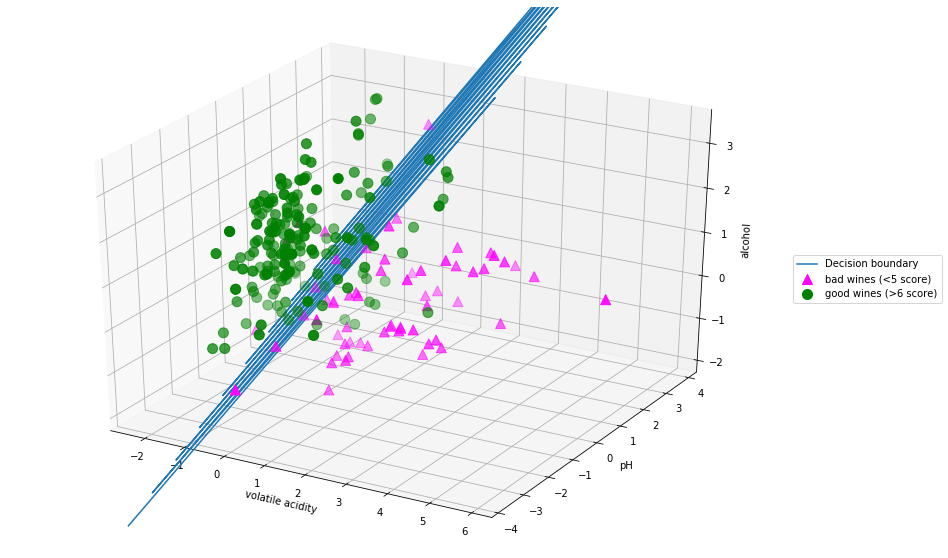

In [52]:
plot_decision_boundary_3D(performance, df_scaled, 7, 4)

## Sources:  
https://sebastianraschka.com/Articles/2015_singlelayer_neurons.html  
https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e  
https://medium.com/@thomascountz/calculate-the-decision-boundary-of-a-single-perceptron-visualizing-linear-separability-c4d77099ef38
https://www.youtube.com/watch?v=PnHCvfgC_ZA&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ&index=4